In [1]:
import numpy as np
import pandas as pd
import glob
from astropy.table import Table
import matplotlib.pyplot as plt
import json 
import collections
import astropy

In [2]:
sample = Table.read("C:/Users/20xha/Documents/Caltech/Research/superfit/ZTFI_data/sample/SEDM_ML_sample.ascii", format = "ascii")
sample.rename_column('col1', 'ZTF_Name')
sample.rename_column('col2', "Class")
sample.rename_column('col3', "redshift")
sample.rename_column('col8', "Version")

In [3]:
class_new = Table.from_pandas(pd.read_csv(r'thermonuclear-white-dwarf-classifications2.csv'))

In [10]:
classification = class_new[np.where(class_new["workflow_version"] == 98.24)[0]]

In [11]:
classification[0]

classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
int64,str34,float64,str20,int64,str25,float64,str23,float64,float64,str2781,str532,str485,int64
358676930,adamamiller,1499915.0,35e103766a70be60d82a,16841,Thermonuclear White Dwarf,98.24,2021-09-09 16:45:49 UTC,--,--,"{""source"":""api"",""session"":""8d448746e8584bebc2cb489ab6e4ab59767927c16abd8e3143db62c3d3a1a602"",""viewport"":{""width"":1380,""height"":905},""started_at"":""2021-09-09T16:45:25.852Z"",""user_agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:91.0) Gecko/20100101 Firefox/91.0"",""utc_offset"":""18000"",""finished_at"":""2021-09-09T16:45:49.132Z"",""live_project"":true,""interventions"":{""opt_in"":true,""messageShown"":false},""user_language"":""en"",""user_group_ids"":[],""subject_dimensions"":[{""clientWidth"":880,""clientHeight"":495,""naturalWidth"":4800,""naturalHeight"":2700},{""clientWidth"":880,""clientHeight"":495,""naturalWidth"":4800,""naturalHeight"":2700}],""subject_selection_state"":{""retired"":true,""selected_at"":""2021-09-09T16:45:25.885Z"",""already_seen"":false,""selection_state"":""failover_fallback"",""finished_workflow"":true,""user_has_finished_workflow"":true},""workflow_translation_id"":""39161""}","[{""task"":""T0"",""value"":[{""choice"":""NONSNAGNORCVORGALORETC"",""answers"":{""NOTASNSUBTYPE"":""CV"",""HOWDIDYOUARRIVEATTHISCLASSIFICATION"":""MARSHAL"",""IFSNIDSUPERFITWHICHIMAGEPROVIDESTHEBESTMATCHMARSHAL999"":""999""},""filters"":{}}]}]","{""65796265"":{""retired"":{""id"":89596465,""workflow_id"":16841,""classifications_count"":4,""created_at"":""2021-08-10T19:06:21.180Z"",""updated_at"":""2021-08-26T07:58:35.558Z"",""retired_at"":""2021-08-26T07:58:35.549Z"",""subject_id"":65796265,""retirement_reason"":""classification_count""},""Fritz"":""https://fritz.science/source/ZTF18ablvazp"",""z_obs"":""-"",""Marshall"":""http://skipper.caltech.edu:8080/cgi-bin/growth/view_source.cgi?name=ZTF18ablvazp"",""ZTF_Name"":""ZTF18ablvazp""}}",65796265


In [12]:
subject_ids_unique = np.unique(classification["subject_ids"])

In [13]:
data = []
counter = 0
for ids in subject_ids_unique:
    if(counter % 200 == 0):
        print(counter)
    counter += 1
    lines = np.where(classification["subject_ids"] == ids)[0]
    data.append([ids, lines])

0
200
400
600
800
1000


In [14]:
data_np = np.asarray(data)

In [15]:
data_array = []
max_len = 0
for i in data_np:
    if(len(i[1]) > 1):
        if(len(i[1])> max_len):
            max_len = len(i[1])
        data_array.append([i[0], classification[i[1]]])
max_len

2

In [16]:
len(data_array)

442

In [17]:
data_array[33][1]

classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
int64,str34,float64,str20,int64,str25,float64,str23,float64,float64,str2781,str532,str485,int64
395795654,Young-Lo,1945442.0,4228e1b45b2ae830fef8,16841,Thermonuclear White Dwarf,98.24,2022-02-09 16:10:44 UTC,--,--,"{""source"":""api"",""session"":""0d12b3b994bf8397f6191eb5dc4d56936590e4c7c68f806021e91421d7fdbc21"",""viewport"":{""width"":1426,""height"":801},""started_at"":""2022-02-09T16:09:25.548Z"",""user_agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.3 Safari/605.1.15"",""utc_offset"":""0"",""finished_at"":""2022-02-09T16:10:44.030Z"",""live_project"":true,""interventions"":{""opt_in"":true,""messageShown"":false},""user_language"":""en"",""user_group_ids"":[],""subject_dimensions"":[{""clientWidth"":908,""clientHeight"":511,""naturalWidth"":4800,""naturalHeight"":2700}],""subject_selection_state"":{""retired"":false,""selected_at"":""2022-02-09T16:08:35.446Z"",""already_seen"":false,""selection_state"":""normal"",""finished_workflow"":false,""user_has_finished_workflow"":false},""workflow_translation_id"":""39161""}","[{""task"":""T0"",""value"":[{""choice"":""SNIA91T"",""answers"":{""HOWDIDYOUARRIVEATTHISCLASSIFICATION"":""SNID"",""IFSNIDSUPERFITWHICHIMAGEPROVIDESTHEBESTMATCHMARSHAL999"":""1""},""filters"":{}}]}]","{""68677647"":{""retired"":{""id"":92576000,""workflow_id"":16841,""classifications_count"":2,""created_at"":""2021-09-15T02:06:51.243Z"",""updated_at"":""2022-03-14T15:02:11.529Z"",""retired_at"":""2022-03-14T15:02:11.522Z"",""subject_id"":68677647,""retirement_reason"":""classification_count""},""Fritz"":""https://fritz.science/source/ZTF18acrfklz"",""z_obs"":""0.12"",""Marshall"":""http://skipper.caltech.edu:8080/cgi-bin/growth/view_source.cgi?name=ZTF18acrfklz"",""ZTF_Name"":""ZTF18acrfklz""}}",68677647
402595940,K-Ryan,2390483.0,50e8858c52aba174b5c9,16841,Thermonuclear White Dwarf,98.24,2022-03-14 15:02:11 UTC,--,--,"{""source"":""api"",""session"":""ea606f226e2512d06af73f3bd465dee7ec6446cc19f5d1a2b270b67e8e19d49c"",""viewport"":{""width"":1440,""height"":820},""started_at"":""2022-03-14T15:01:52.667Z"",""user_agent"":""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/15.3 Safari/605.1.15"",""utc_offset"":""0"",""finished_at"":""2022-03-14T15:02:11.296Z"",""live_project"":true,""interventions"":{""opt_in"":true,""messageShown"":false},""user_language"":""en"",""user_group_ids"":[],""subject_dimensions"":[{""clientWidth"":936,""clientHeight"":527,""naturalWidth"":4800,""naturalHeight"":2700}],""subject_selection_state"":{""retired"":false,""selected_at"":""2022-03-14T15:01:13.384Z"",""already_seen"":false,""selection_state"":""normal"",""finished_workflow"":false,""user_has_finished_workflow"":false},""workflow_translation_id"":""39161""}","[{""task"":""T0"",""value"":[{""choice"":""SNIA91T"",""answers"":{""HOWDIDYOUARRIVEATTHISCLASSIFICATION"":""SNID"",""IFSNIDSUPERFITWHICHIMAGEPROVIDESTHEBESTMATCHMARSHAL999"":""1""},""filters"":{}}]}]","{""68677647"":{""retired"":{""id"":92576000,""workflow_id"":16841,""classifications_count"":2,""created_at"":""2021-09-15T02:06:51.243Z"",""updated_at"":""2022-03-14T15:02:11.529Z"",""retired_at"":""2022-03-14T15:02:11.522Z"",""subject_id"":68677647,""retirement_reason"":""classification_count""},""Fritz"":""https://fritz.science/source/ZTF18acrfklz"",""z_obs"":""0.12"",""Marshall"":""http://skipper.caltech.edu:8080/cgi-bin/growth/view_source.cgi?name=ZTF18acrfklz"",""ZTF_Name"":""ZTF18acrfklz""}}",68677647


In [18]:
ResultsTable_Zooniverse = Table(
                    names=("ZTF_Name", "subject_ids", "classifier_1", "classification_1", "best_match_1", "classifier_2", "classification_2", "best_match_2", "classifier_3", "classification_3", "best_match_3", "classifier_4", "classification_4", "best_match_4", "classifier_5", "classification_5", "best_match_5"
                    ),
                    meta={"name": "Spectrum Results after Zooniverse"},
                    dtype=("U64", "int32", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64", "U64"
                          )
                    )
for line in data_array:
    row = []
    data = line[1]
    metadata = json.loads(data[0]["subject_data"])[str(line[0])]
    row.append(metadata["ZTF_Name"])
    row.append(line[0])
    for i in data:
        if(i["user_name"] not in row):
            row.append(i["user_name"])
            value = json.loads(i["annotations"])[0]["value"]
            if(value is not None):
                given_type = value[0]["choice"]
                if(given_type == "NOGOODMATCH"):
                    row.extend([given_type, "NA"])
                else:
                    if(given_type == "NONSNAGNORCVORGALORETC"):
                        given_type = given_type# + "-" + value[0]["answers"]["NOTASNSUBTYPE"]
                    row.append(given_type)
                    row.append(value[0]["answers"]["WHICHIMAGEPROVIDESTHEBESTMATCH"])
    if(len(row) == 8):
        row.extend(["NA","NA","NA","NA","NA","NA","NA","NA","NA"])
    if(len(row) == 11):
        row.extend(["NA","NA","NA","NA","NA","NA"])
    if(len(row) == 14):
        row.extend(["NA","NA","NA"])
    ResultsTable_Zooniverse.add_row(row)

KeyError: 'WHICHIMAGEPROVIDESTHEBESTMATCH'

In [20]:
row

['ZTF18abokhip', 68677455, 'steveschulze', 'CANNOTBECLASSIFIED']

In [13]:
value[0]["choice"]

'NOGOODMATCH'

In [14]:
len(row)

17

In [15]:
value[0]

{'choice': 'NOGOODMATCH', 'answers': {}, 'filters': {}}

In [30]:
np.sum(ResultsTable_Zooniverse["classification_1"] == "NOGOODMATCH")

91

In [31]:
np.sum(ResultsTable_Zooniverse["classification_2"] == "NOGOODMATCH")

45

In [16]:
agree = []
agree_id = []
disagree_id = []
counter = 0
for i in ResultsTable_Zooniverse:
    classes = i["classification_1", "classification_2", "classification_3", "classification_4", "classification_5"]
    class_list = list(classes)
    class_list[:] = [x for x in class_list if x != "NA"]
    class_list[:] = [x for x in class_list if x != "NOGOODMATCH"]
    if(len(class_list) > 1):
        unique = np.unique(class_list)
        if(len(unique) == 1):
            agree.append(i["ZTF_Name"])
            agree_id.append(counter)
        else:
            disagree_id.append(counter)
    else:
        disagree_id.append(counter)
    counter += 1

In [17]:
len(agree)

49

In [18]:
np.sum(ResultsTable_Zooniverse[disagree_id]["classification_1"] == "NOGOODMATCH")

88

In [19]:
joined_table = astropy.table.join(ResultsTable_Zooniverse[agree_id], sample)

In [20]:
joined_table["ZTF_Name", "classification_1", "Class"]

ZTF_Name,classification_1,Class
str64,str64,str12
ZTF17aaajnki,NONSNAGNORCVORGALORETC,AGN
ZTF17aaajnki,NONSNAGNORCVORGALORETC,AGN
ZTF18aaadtdc,NONSNAGNORCVORGALORETC,AGN
ZTF18aaaibml,SNIIN,II
ZTF18aaaibml,SNIIN,II
ZTF18aaaibml,SNIIN,II
ZTF18aaaibml,SNIIN,II
ZTF18aabvpbb,NONSNAGNORCVORGALORETC,CV
ZTF18aacopwm,NONSNAGNORCVORGALORETC,-


In [33]:
ResultsTable_Zooniverse[np.where(ResultsTable_Zooniverse["ZTF_Name"] == "ZTF18abnnnzk")]

ZTF_Name,subject_ids,classifier_1,classification_1,best_match_1,classifier_2,classification_2,best_match_2,classifier_3,classification_3,best_match_3,classifier_4,classification_4,best_match_4,classifier_5,classification_5,best_match_5
str64,int32,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64,str64
ZTF18abnnnzk,65796278,samanthagoldwasser,SNIINORM,1,mrchu,SNIINORM,1,RachelJBruch,SNIINORM,1,NA,NA,NA,NA,NA,NA


In [22]:
classifiers = []
for i in ["classifier_1", "classifier_2", "classifier_3", "classifier_4", "classifier_5"]:
    classifiers.extend(list(ResultsTable_Zooniverse[i]))
classifiers[:] = [x for x in classifiers if x != "NA"]

In [23]:
unique_names = np.unique(classifiers)
nums = []
for i in unique_names:
    nums.append(classifiers.count(i))
nums = np.asarray(nums)

<BarContainer object of 10 artists>

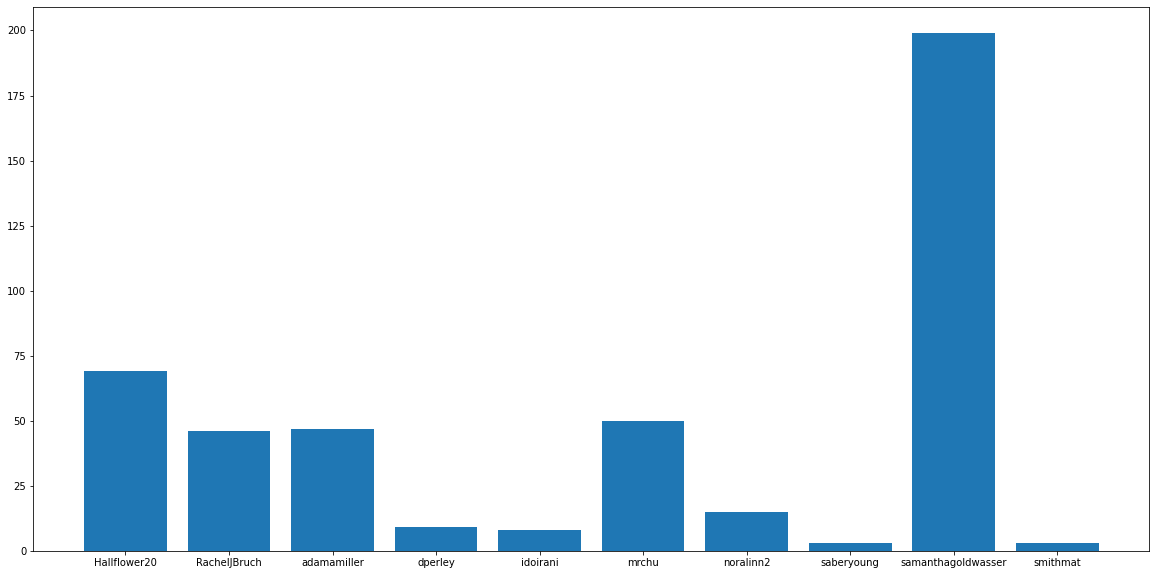

In [24]:
fig = plt.figure(figsize = (20,10))
plt.bar(unique_names, nums)

In [25]:
len(nums)

10

In [26]:
len(unique_names)

10